In [22]:
import pandas as pd

# surveillance des GPU/RAm/etc.
import GPUtil

# vectorisation des textes
import torch

In [23]:
# pour un ordi avec GPU
def diag_GPU() :
    if torch.cuda.is_available() is True:
        print("Using GPU!")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        print("GPU Usage")
        GPUtil.showUtilization()
        print(f"numbers GPU on this machine : {torch.cuda.device_count()}")
        print(f"id of the GPU used : {torch.cuda.current_device()}, name : {torch.cuda.get_device_name(0)}")
        print(f"cuda usage of th GPU : {torch.cuda.memory_allocated(torch.cuda.current_device())}")

    else : 
        print("torch.cuda.is_available() is False")

In [24]:
df = pd.read_csv("df_CC_lemmas_postag_corrected.csv", sep = ",", encoding = "utf-8", dtype= str)

# pour faire un random sample d'un petit échantillon
# df = df.sample(1000)

df["lemmas_without_stopwords"] = df["lemmas without stopwords"]
# la fonction .tolist() n'accepte pas les espace dans les noms de colonnes

In [25]:
lemmatized = df.lemmas_without_stopwords.tolist()
lemmatized[30]

"['augmenter', 'salaire', 'fonctionnaire', 'diminuer', 'taxe', 'service', 'revoir', 'convention', 'aide', 'domicile', 'prix', 'kilomètre', 'plupart', 'travailler', 'voiture', 'personnel', 'prix', 'proposer', 'prendre', 'charge', 'réalité', 'voiture', 'maire', 'm', 'besoin', 'entretien', 'pourtant', 'travail', 'domicile', 'permettre', 'accompagner', 'difficulté', 'social', 'malade', 'cadre', 'papier', 'administ', 'extérieure', 'prix', 'association', 'institution', 'temps', 'réfléchir', 'lire', 'comprendre', 'développement', 'ligne', 'ferroviaire', 'olorov', 'augmentation', 'horaire', 'cadencement', 'buzy', 'solution', 'permettre', 'diminuer', 'nombre', 'voiture', 'route', 'accidenter', 'gérer', 'préserver', 'environnement']"

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
# Default stop_words = None is used. In this case, setting max_df to a higher value, such as in the range (0.7, 1.0), can automatically detect and filter stop words based on intra corpus document frequency of terms.
tf = tf_vectorizer.fit_transform(lemmatized)

In [37]:
diag_GPU()

Using GPU!
GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  7% | 57% |
numbers GPU on this machine : 1
id of the GPU used : 0, name : Quadro M2000
cuda usage of th GPU : 0


In [29]:
# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

In [30]:
# Fit sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [35]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names_out(), 10)

Topic 0:
retraite suppression salaire augmentation vie csg président député retraité isf
Topic 1:
doléance monsieur cahier débat souhaiter mairie pouvoir grand maire national
Topic 2:
service public transport écologique transition devoir pouvoir énergie commune rural
Topic 3:
petit entreprise société patron mairie 01 dividende social taxe cotisation
Topic 4:
vote élu citoyen député devoir élection nombre blanc référendum national
Topic 5:
impôt fiscal pourcent revenu euro social entreprise public devoir dépense
Topic 6:
taxe produit tva kilomètre impôt heure carburant taxer supprimer augmenter
Topic 7:
pouvoir devoir faire pays français politique falloir citoyen bien grand
Topic 8:
faire pouvoir enfant payer travailler travail falloir bien euro aller
Topic 9:
service public oui falloir faire aujourd hui administration réponse vie


In [32]:
import matplotlib.pyplot as plt


In [33]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [42]:
def show_topics(vectorizer= tf_vectorizer, lda_model=lda, n_words=20):
    keywords = tf_vectorizer.get_feature_names_out()
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=tf, lda_model=lda, n_words=20)        




df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords
# a enregistrer en csv

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,retraite,suppression,salaire,augmentation,vie,csg,président,député,retraité,isf,avantage,ministre,ancien,euro,sénateur,pension,fonctionnaire,privilège,smic,inflation
Topic 1,doléance,monsieur,cahier,débat,souhaiter,mairie,pouvoir,grand,maire,national,ville,proposition,fr,demande,proposer,public,date,ordre,priorité,nom
Topic 2,service,public,transport,écologique,transition,devoir,pouvoir,énergie,commune,rural,permettre,local,place,santé,favoriser,territoire,développer,grand,entreprise,ville
Topic 3,petit,entreprise,société,patron,mairie,01,dividende,social,taxe,cotisation,risque,2019,soumettre,collectif,cahier,entrepreneur,impôt,pourcent,revendication,prendre
Topic 4,vote,élu,citoyen,député,devoir,élection,nombre,blanc,référendum,national,commune,assemblée,mandat,compte,conseil,loi,non,parlementaire,pouvoir,région
Topic 5,impôt,fiscal,pourcent,revenu,euro,social,entreprise,public,devoir,dépense,payer,français,milliard,fiscalité,état,emploi,travail,aide,taux,réduire
Topic 6,taxe,produit,tva,kilomètre,impôt,heure,carburant,taxer,supprimer,augmenter,pourcent,route,prix,voiture,vitesse,véhicule,nécessité,trop,baisse,habitation
Topic 7,pouvoir,devoir,faire,pays,français,politique,falloir,citoyen,bien,grand,peuple,droit,loi,gouvernement,social,société,question,aller,vouloir,prendre
Topic 8,faire,pouvoir,enfant,payer,travailler,travail,falloir,bien,euro,aller,retraite,devoir,trop,petit,mois,vivre,voir,monsieur,vie,prendre
Topic 9,service,public,oui,falloir,faire,aujourd,hui,administration,réponse,vie,pourcent,mourir,non,actif,penser,aide,débat,pouvoir,état,grand


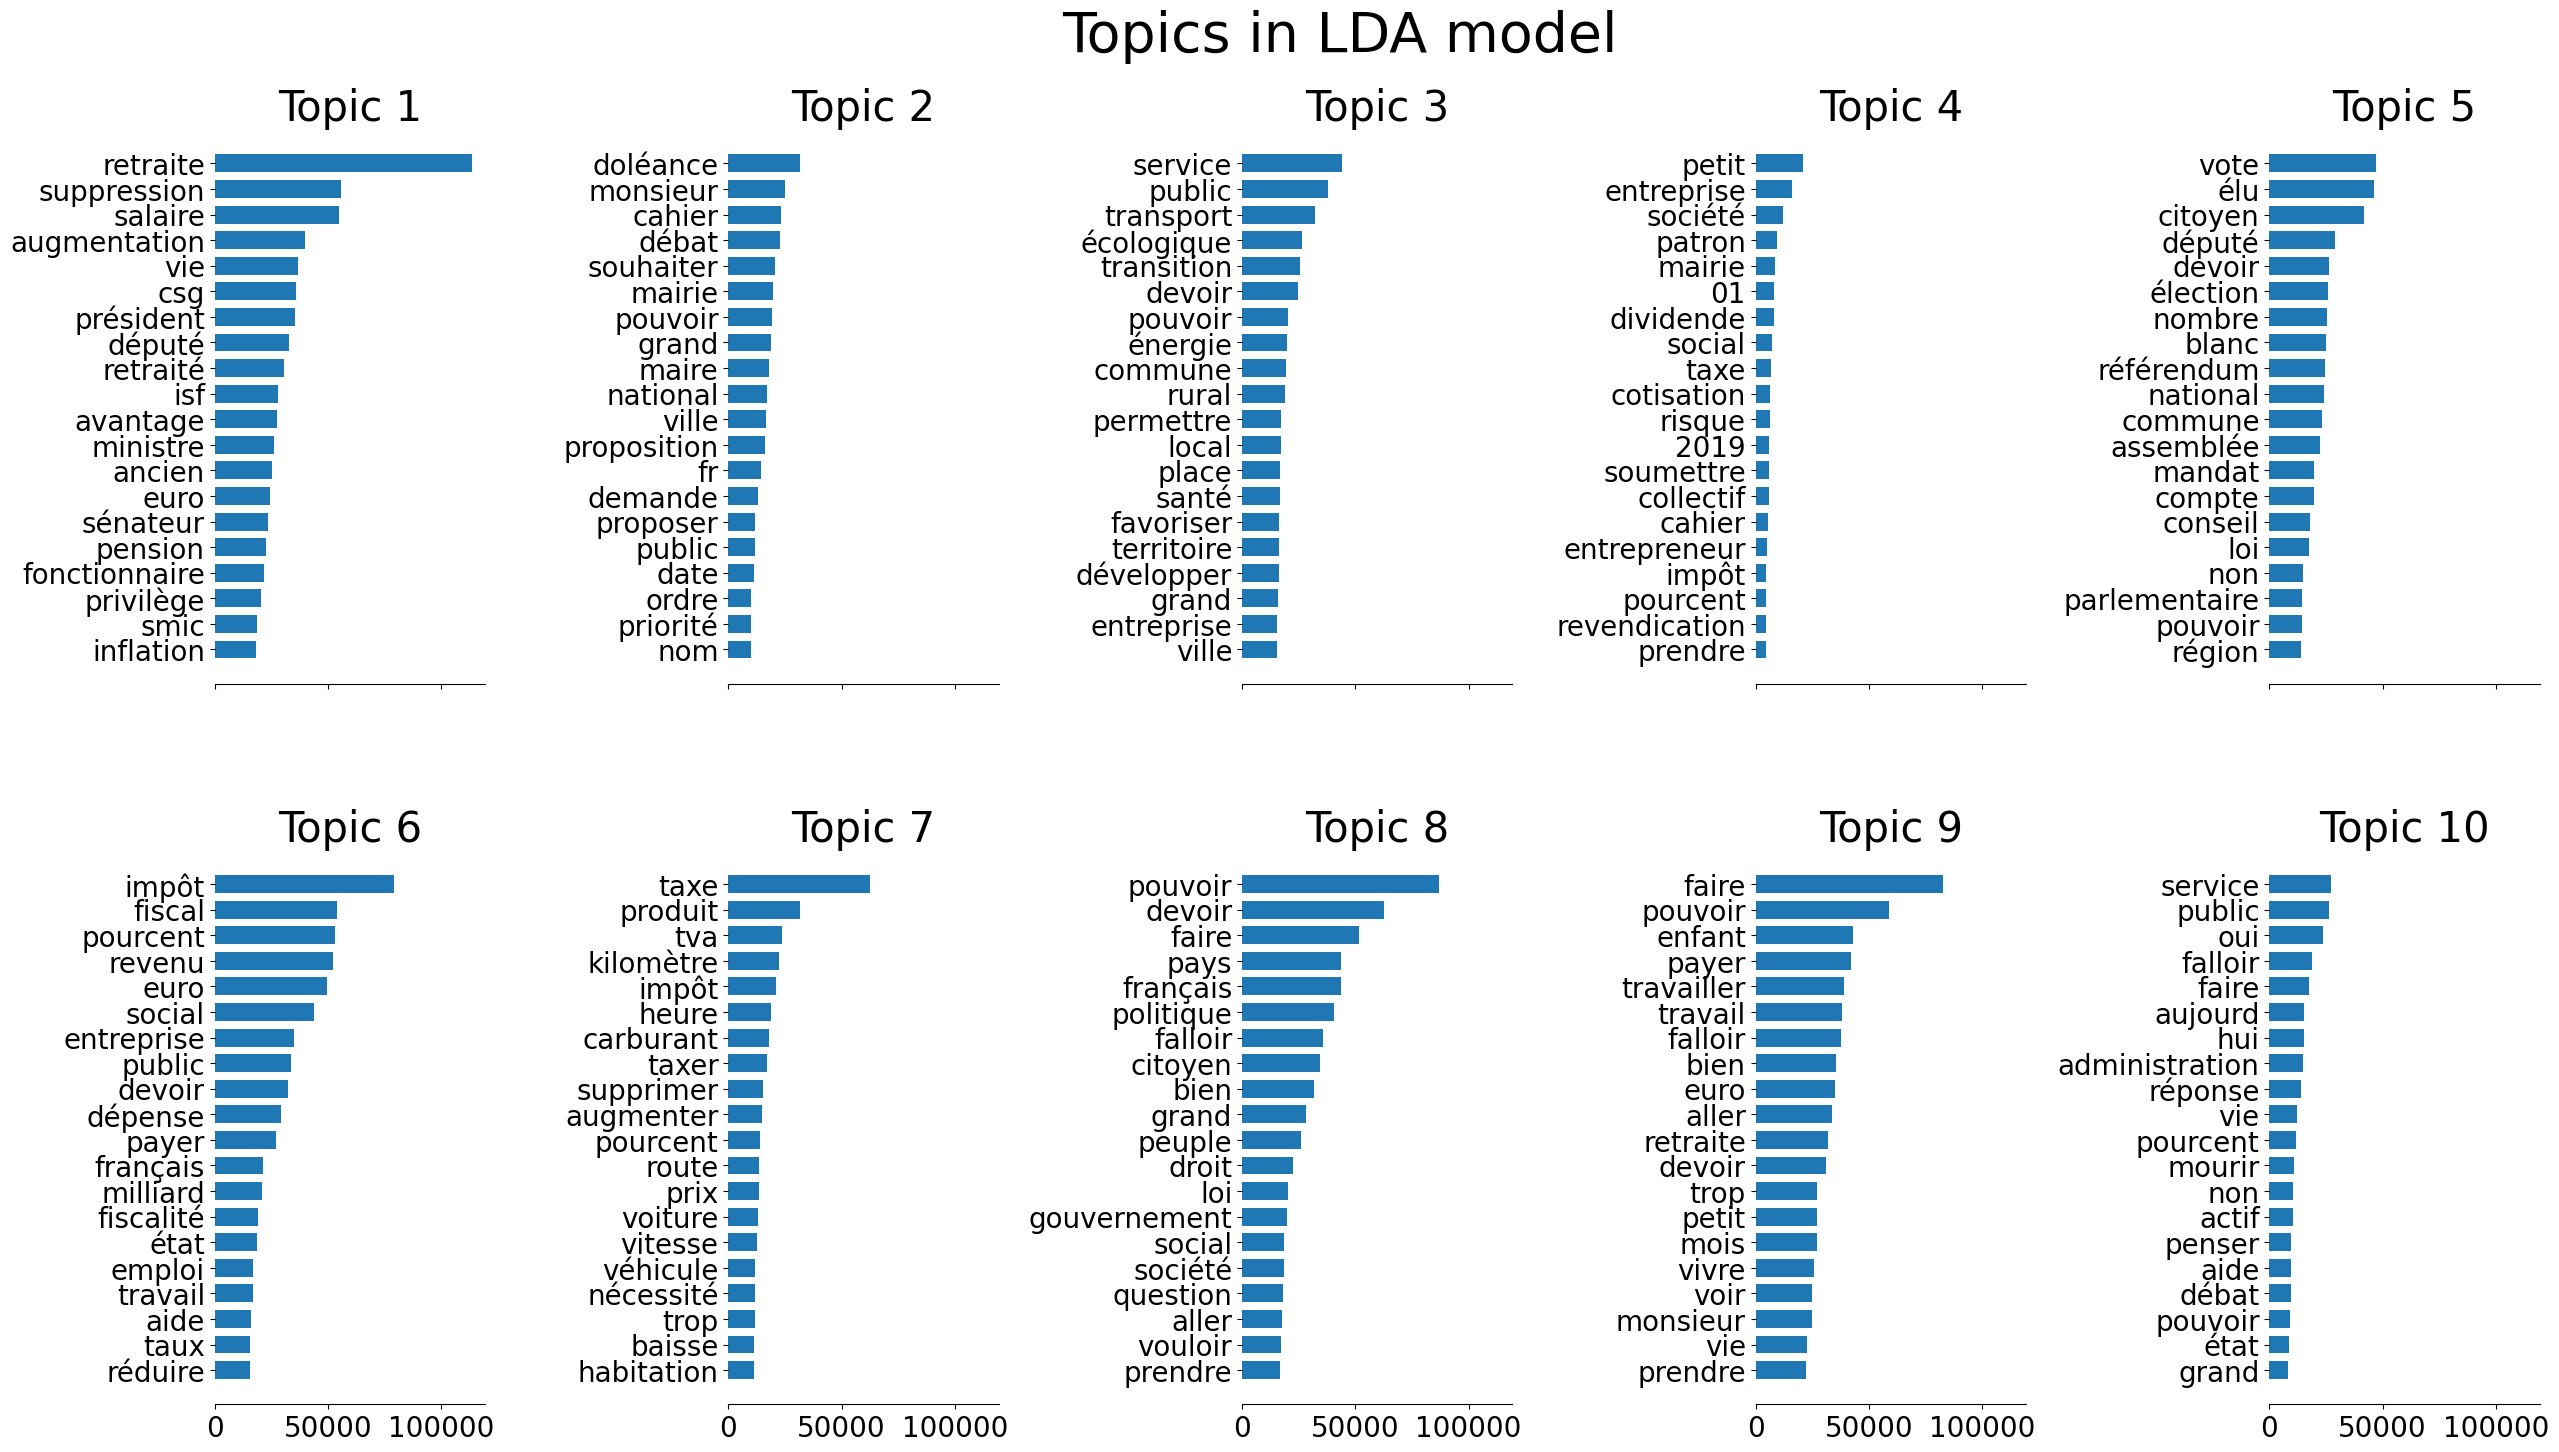

In [36]:
tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, 20, "Topics in LDA model")

In [ ]:
import pyLDAvis
# need admin

In [ ]:
pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)

In [ ]:
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [ ]:
# Computes the frequency of all word forms in the train set.
word_counts = collections.defaultdict(int)
# keys will be given, key added if not existant, values will be int
for tokens in lemmatized:
  for token in tokens: word_counts[token] += 1

print(len(word_counts))

In [ ]:
count_threshold = 1
vocabulary = set()
for word, count in word_counts.items():
    if(count > count_threshold): vocabulary.add(word)

# print(vocabulary)
print(len(vocabulary))